In [12]:
# added because the logging was annoying
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
%load_ext autoreload
%autoreload 1
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.models import load_model
import numpy as np
from sklearn.utils import shuffle
from keras.layers import Concatenate, Dense, Dropout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# custom imports
%aimport database_utils 
%aimport models 

In [3]:
CONNECTION_STRING = 'connect.txt'
K = 10

In [4]:
curr = database_utils.makeHerokuDBConnection(CONNECTION_STRING)
users, houses, matches, num_users, num_houses = database_utils.fetchHerokuData(curr) 

In [5]:
model= models.recommenderModel(K, num_users, num_houses, users, houses, matches)

Train on 3287 samples, validate on 500 samples
Epoch 1/100
3287/3287 [==============================] - 0s 141us/step - loss: 0.4147 - acc: 0.5674 - val_loss: 0.2865 - val_acc: 0.6100
Epoch 2/100
3287/3287 [==============================] - 0s 38us/step - loss: 0.4124 - acc: 0.5786 - val_loss: 0.2852 - val_acc: 0.5820
Epoch 3/100
3287/3287 [==============================] - 0s 40us/step - loss: 0.4244 - acc: 0.5513 - val_loss: 0.2612 - val_acc: 0.6780
Epoch 4/100
3287/3287 [==============================] - 0s 45us/step - loss: 0.3916 - acc: 0.5808 - val_loss: 0.2262 - val_acc: 0.6640
Epoch 5/100
3287/3287 [==============================] - 0s 45us/step - loss: 0.3866 - acc: 0.5963 - val_loss: 0.2304 - val_acc: 0.7260
Epoch 6/100
3287/3287 [==============================] - 0s 49us/step - loss: 0.4220 - acc: 0.5701 - val_loss: 0.2373 - val_acc: 0.6820
Epoch 7/100
3287/3287 [==============================] - 0s 58us/step - loss: 0.3765 - acc: 0.5975 - val_loss: 0.1955 - val_acc: 0.7280


3287/3287 [==============================] - 0s 47us/step - loss: 0.4325 - acc: 0.5847 - val_loss: 0.2383 - val_acc: 0.6900
Epoch 61/100
3287/3287 [==============================] - 0s 39us/step - loss: 0.4355 - acc: 0.5884 - val_loss: 0.2339 - val_acc: 0.7000
Epoch 62/100
3287/3287 [==============================] - 0s 42us/step - loss: 0.3843 - acc: 0.6100 - val_loss: 0.2165 - val_acc: 0.6740
Epoch 63/100
3287/3287 [==============================] - 0s 47us/step - loss: 0.3635 - acc: 0.6307 - val_loss: 0.1966 - val_acc: 0.7140
Epoch 64/100
3287/3287 [==============================] - 0s 78us/step - loss: 0.3572 - acc: 0.6282 - val_loss: 0.2082 - val_acc: 0.7120
Epoch 65/100
3287/3287 [==============================] - 0s 48us/step - loss: 0.3621 - acc: 0.6243 - val_loss: 0.2241 - val_acc: 0.6920
Epoch 66/100
3287/3287 [==============================] - 0s 43us/step - loss: 0.3728 - acc: 0.6203 - val_loss: 0.2227 - val_acc: 0.7020
Epoch 67/100
3287/3287 [==============================

In [8]:
database_utils.makePredictionsAndComputeAccuracy(model, [users[:500], houses[:500]], matches[:500])

0.624


In [9]:
model.save('recommender_save.h5')

In [13]:
prev_model = load_model('recommender.h5')
prev_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        310         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        23070       input_2[0][0]                    
____________________________________________________________________________________________

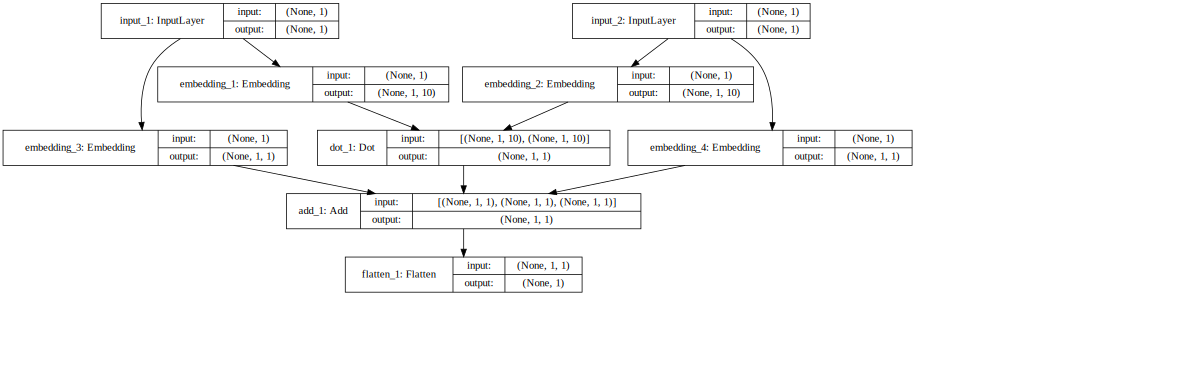

In [14]:
SVG(model_to_dot(prev_model, show_shapes= True, show_layer_names=True, dpi=55).create(prog='dot', format='svg'))